In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [59]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

 ### Clean data from oasis_cross_sectional.csv and find corresponding MRI images in image folders for each ID.

In [29]:
# Load Cross Sectional MRI Data
# Change the path to your own.
cross_sectional_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/final project/Input/oasis_cross-sectional.csv')

cross_sectional_df

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
431,OAS1_0285_MR2,M,R,20,NaN,NaN,NaN,NaN,1469,0.847,1.195,2.0
432,OAS1_0353_MR2,M,R,22,NaN,NaN,NaN,NaN,1684,0.790,1.042,40.0
433,OAS1_0368_MR2,M,R,22,NaN,NaN,NaN,NaN,1580,0.856,1.111,89.0
434,OAS1_0379_MR2,F,R,20,NaN,NaN,NaN,NaN,1262,0.861,1.390,2.0


In [30]:
# Remove 'Delay' and 'Hand' columns
columns_to_drop = ['Delay', 'Hand']
cross_sectional_df = cross_sectional_df.drop(columns=columns_to_drop)
# Remove rows with NaN values
cross_sectional_df = cross_sectional_df.dropna()
cross_sectional_df

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
411,OAS1_0453_MR1,F,70,1.0,4.0,29.0,0.5,1295,0.748,1.355
412,OAS1_0454_MR1,F,73,3.0,2.0,23.0,0.5,1536,0.730,1.142
413,OAS1_0455_MR1,F,61,2.0,4.0,28.0,0.0,1354,0.825,1.297
414,OAS1_0456_MR1,M,61,5.0,2.0,30.0,0.0,1637,0.780,1.072


In [43]:
# Function to get folder name for a given ID
def get_folder_for_id(id_value):
    base_dir = '/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer Dataset (OASIS)/'
    # Dictionary to map subdirectories to dementia categories
    subdirectory_mapping = {
        'Moderate_Demented': 'Moderate Dementia',
        'Mild_Demented': 'Mild Dementia',
        'Very_Mild_Demented': 'Very Mild Dementia',
        'Non Demented_by_one': 'Non Demented'
    }

    for subdir in subdirectory_mapping:
        subdir_path = os.path.join(base_dir, subdir)

        # List all files in the subdirectory
        files = os.listdir(subdir_path)

        # Check if any file contains the current ID in its name
        matching_files = [file for file in files if id_value in file]

        if matching_files:
            return subdirectory_mapping[subdir]  # Return the corresponding dementia category

    return None  # Return None if no match is found

In [44]:
# Use the apply function to apply get_folder_for_id to each row in the dataframe
# cross_sectional_df['Group'] = cross_sectional_df['ID'].apply(get_folder_for_id)
cross_sectional_df.loc[:, 'Group'] = cross_sectional_df['ID'].apply(get_folder_for_id)
# first_ten_rows['Group'] = first_ten_rows['ID'].apply(get_folder_for_id)
# first_ten_rows
# Display the updated dataframe
cross_sectional_df

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Group
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,Non Demented
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,Non Demented
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,Very Mild Dementia
3,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,Non Demented
4,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,Non Demented
...,...,...,...,...,...,...,...,...,...,...,...
211,OAS1_0453_MR1,F,70,1.0,4.0,29.0,0.5,1295,0.748,1.355,None
212,OAS1_0454_MR1,F,73,3.0,2.0,23.0,0.5,1536,0.730,1.142,None
213,OAS1_0455_MR1,F,61,2.0,4.0,28.0,0.0,1354,0.825,1.297,None
214,OAS1_0456_MR1,M,61,5.0,2.0,30.0,0.0,1637,0.780,1.072,None


In [45]:

# Replace None with NaN in the 'Group' column
cross_sectional_df['Group'] = cross_sectional_df['Group'].replace({None: np.nan})

# Remove rows with NaN values in the 'Group' column
cross_sectional_df = cross_sectional_df.dropna(subset=['Group'])
cross_sectional_df

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Group
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,Non Demented
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,Non Demented
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,Very Mild Dementia
3,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,Non Demented
4,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,Non Demented
...,...,...,...,...,...,...,...,...,...,...,...
177,OAS1_0373_MR1,F,80,3.0,2.0,20.0,1.0,1732,0.692,1.013,Mild Dementia
178,OAS1_0374_MR1,F,73,3.0,3.0,29.0,0.5,1238,0.760,1.418,Very Mild Dementia
179,OAS1_0378_MR1,F,58,2.0,2.0,30.0,0.0,1418,0.821,1.238,Non Demented
180,OAS1_0380_MR1,F,83,1.0,5.0,18.0,0.5,1313,0.705,1.337,Very Mild Dementia


In [46]:
# Reset the index to start from 0
cross_sectional_df.reset_index(drop=True, inplace=True)

# Save the DataFrame to a CSV file
cross_sectional_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/final project/cross_sectional_df.csv', index=False)

In [47]:
cross_sectional_df_copy = cross_sectional_df.copy()

In [48]:
cross_sectional_df_copy

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Group
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,Non Demented
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,Non Demented
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,Very Mild Dementia
3,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,Non Demented
4,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,Non Demented
...,...,...,...,...,...,...,...,...,...,...,...
177,OAS1_0373_MR1,F,80,3.0,2.0,20.0,1.0,1732,0.692,1.013,Mild Dementia
178,OAS1_0374_MR1,F,73,3.0,3.0,29.0,0.5,1238,0.760,1.418,Very Mild Dementia
179,OAS1_0378_MR1,F,58,2.0,2.0,30.0,0.0,1418,0.821,1.238,Non Demented
180,OAS1_0380_MR1,F,83,1.0,5.0,18.0,0.5,1313,0.705,1.337,Very Mild Dementia


## Prediction using logistic regression model

In [49]:
# Load the trained logistic regression model
# Change the path to your own.
trained_model = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/final project/final_model.pkl')

# Load the list of feature names
# Change the path to your own.
feature_names = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/final project/column_names.pkl')

In [50]:
# Rename 'Educ' column to 'EDUC' in-place
cross_sectional_df_copy.rename(columns={'M/F': 'Sex'}, inplace=True)

# Replace 'F' with 1 and 'M' with 0 in the 'Sex' column using .loc
cross_sectional_df_copy['Sex'] = cross_sectional_df_copy['Sex'].replace({'F': 1, 'M': 0})


In [51]:
# Rename 'Educ' column to 'EDUC' in-place
cross_sectional_df_copy.rename(columns={'Educ': 'EDUC'}, inplace=True)

In [11]:
cross_sectional_df_copy

,ID,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Group
0,OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,Non Demented
1,OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,Non Demented
2,OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,Very Mild Dementia
8,OAS1_0010_MR1,0,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,Non Demented
9,OAS1_0011_MR1,1,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,Non Demented
...,...,...,...,...,...,...,...,...,...,...,...
337,OAS1_0373_MR1,1,80,3.0,2.0,20.0,1.0,1732,0.692,1.013,Mild Dementia
338,OAS1_0374_MR1,1,73,3.0,3.0,29.0,0.5,1238,0.760,1.418,Very Mild Dementia
342,OAS1_0378_MR1,1,58,2.0,2.0,30.0,0.0,1418,0.821,1.238,Non Demented
344,OAS1_0380_MR1,1,83,1.0,5.0,18.0,0.5,1313,0.705,1.337,Very Mild Dementia


In [56]:
# Select features for prediction
X_sample = cross_sectional_df_copy[feature_names]

# Create a new StandardScaler and fit_transform on the same data used for training
scaler = StandardScaler()
X_sample_scaled = pd.DataFrame(scaler.fit_transform(X_sample), columns=X_sample.columns)

# Make predictions using the trained model
predictions = trained_model.predict(X_sample_scaled)

# Create a new column for predicted values and initialize with NaN
cross_sectional_df_copy['predicted'] = np.nan

# Fill predicted values for non-NaN rows
cross_sectional_df_copy = cross_sectional_df_copy.reindex(X_sample_scaled.index)
cross_sectional_df_copy.loc[X_sample_scaled.index, 'predicted'] = predictions

# Replace 0 and 1 with 'Nondemented' and 'Demented'
cross_sectional_df_copy['predicted'] = cross_sectional_df_copy['predicted'].replace({0: 'Nondemented', 1: 'Demented'})

# Check the updated dataframe
cross_sectional_df_copy

<ipython-input-56-a260cd7f3be5>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cross_sectional_df_copy.loc[X_sample_scaled.index, 'predicted'] = predictions


,ID,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Group,predicted
0,OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,Non Demented,Nondemented
1,OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,Non Demented,Demented
2,OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,Very Mild Dementia,Demented
3,OAS1_0010_MR1,0,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,Non Demented,Nondemented
4,OAS1_0011_MR1,1,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,Non Demented,Nondemented
...,...,...,...,...,...,...,...,...,...,...,...,...
177,OAS1_0373_MR1,1,80,3.0,2.0,20.0,1.0,1732,0.692,1.013,Mild Dementia,Demented
178,OAS1_0374_MR1,1,73,3.0,3.0,29.0,0.5,1238,0.760,1.418,Very Mild Dementia,Demented
179,OAS1_0378_MR1,1,58,2.0,2.0,30.0,0.0,1418,0.821,1.238,Non Demented,Nondemented
180,OAS1_0380_MR1,1,83,1.0,5.0,18.0,0.5,1313,0.705,1.337,Very Mild Dementia,Demented


In [57]:
# Count the occurrences of each combination of 'Group' and 'predicted'
count_table = cross_sectional_df_copy.groupby(['Group', 'predicted']).size().unstack(fill_value=0)
count_table

predicted,Demented,Nondemented
Group,,
Mild Dementia,18,0
Moderate Dementia,2,0
Non Demented,9,108
Very Mild Dementia,44,1


## Prediction (Classify dementia) using CNN model or SVM model

In [60]:
# Load the trained model
model = load_model("/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer(OASIS)ThreeCategories.h5")

In [74]:
# Specify the image folder paths
id_value = 'OAS1_0003_MR1'
# Each patient took at most 4 MRI. Select the desired MRI number (1 for the first, 2 for the second, etc.)
mri_number = 1

group_for_id = cross_sectional_df_copy.loc[cross_sectional_df_copy['ID'] == id_value, 'Group'].values[0]

if group_for_id == 'Very Mild Dementia':
    image_folder = "/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer Dataset (OASIS)/Very_Mild_Demented"
elif group_for_id == 'Mild Dementia':
    image_folder = "/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer Dataset (OASIS)/Mild_Demented"

image_name_prefix = f"{id_value}_mpr-{mri_number}"


In [75]:
# Get a list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Filter filenames based on the image name prefix
filtered_files = [f for f in image_files if f.startswith(image_name_prefix)]

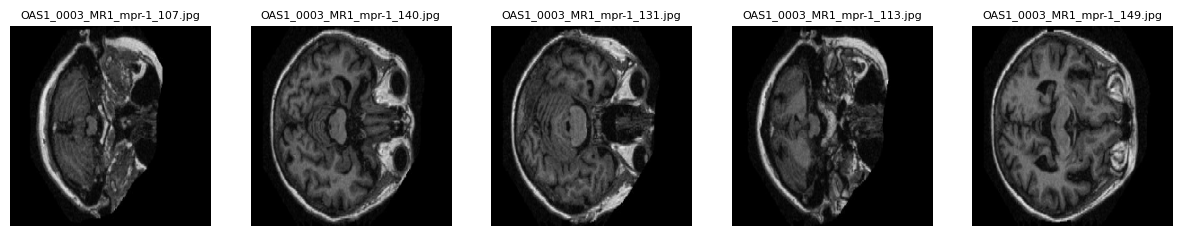

In [76]:
# Display the first 5 filtered images
import random

num_images_to_display = 5

# Randomly select five images from the filtered_files list
random_images = random.sample(filtered_files, num_images_to_display)

# Display the randomly selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, image_file in enumerate(random_images):
    img_path = os.path.join(image_folder, image_file)
    img = image.load_img(img_path, target_size=(224, 224))

    # Display the image
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_file, fontsize=8)

plt.show()

In [77]:
class_labels = ['Mild_Dementia' 'Moderate_Dementia' 'Very_Mild_Dementia']
# Create a list to store DataFrames
dfs = []

# Loop through each filtered image and make predictions
for image_file in filtered_files:
    # Load and preprocess the image
    img_path = os.path.join(image_folder, image_file)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to between 0 and 1

    # Make prediction
    prediction = model.predict(img_array)

    # Round the prediction values to two decimal places
    rounded_prediction = np.round(prediction, 2)

    # print(f"Prediction for {image_file}: {rounded_prediction}")

    # Create a DataFrame for each prediction
    result_df = pd.DataFrame({
        'Image_Name': [image_file],
        'Predicted_Mild_Dementia': [rounded_prediction[0][0]],  # Index 0 corresponds to 'Mild_Demented'
        'Predicted_Moderate_Dementia': [rounded_prediction[0][1]],  # Index 1 corresponds to 'Moderate_Demented'
        'Predicted_Very_Mild_Dementia': [rounded_prediction[0][2]]  # Index 2 corresponds to 'Very_Mild_Demented'
    })

    # Append the DataFrame to the list
    dfs.append(result_df)

# Concatenate all DataFrames in the list into one DataFrame
result_df = pd.concat(dfs, ignore_index=True)

1/1 [==============================] - 0s 24ms/step


In [78]:
result_df.sort_values(by='Predicted_Very_Mild_Dementia', ascending=False)

,Image_Name,Predicted_Mild_Dementia,Predicted_Moderate_Dementia,Predicted_Very_Mild_Dementia
6,OAS1_0003_MR1_mpr-1_112.jpg,0.01,0.0,0.99
7,OAS1_0003_MR1_mpr-1_113.jpg,0.01,0.0,0.99
0,OAS1_0003_MR1_mpr-1_105.jpg,0.02,0.0,0.98
8,OAS1_0003_MR1_mpr-1_114.jpg,0.02,0.0,0.98
10,OAS1_0003_MR1_mpr-1_116.jpg,0.02,0.0,0.98
...,...,...,...,...
37,OAS1_0003_MR1_mpr-1_147.jpg,0.77,0.0,0.23
29,OAS1_0003_MR1_mpr-1_134.jpg,0.78,0.0,0.22
42,OAS1_0003_MR1_mpr-1_145.jpg,0.80,0.0,0.20
27,OAS1_0003_MR1_mpr-1_136.jpg,0.82,0.0,0.18


In [81]:
# Assuming 'result_df' is your DataFrame
column_means = result_df.mean()

# Display the means with 'ID' and 'Group' values
print("Column Means:")
print(f"ID: {id_value}, Group: {group_for_id}\n")
print(column_means)

Column Means:
ID: OAS1_0003_MR1, Group: Very Mild Dementia

Predicted_Mild_Dementia         0.326721
Predicted_Moderate_Dementia     0.000000
Predicted_Very_Mild_Dementia    0.672623
dtype: float32


<ipython-input-81-c07ebf7f4ce0>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  column_means = result_df.mean()
